# Data preaparation and xgboost regressor training

# Spark set up

In [5]:
import platform
local_os = platform.system()
if local_os == 'Linux':
    !apt-get install openjdk-8-jdk-headless -qq > /dev/null
    !wget https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
    !tar zxvf /content/spark-3.3.1-bin-hadoop3.tgz
    !pip install -q findspark
    import findspark
    findspark.init()

In [10]:
from pyspark.sql import SparkSession

In [16]:
import os
if local_os == 'Linux':
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
    os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"
else:
    os.environ["JAVA_HOME"] = "/opt/homebrew/opt/openjdk/"


In [17]:
spark = SparkSession.builder\
        .master("local")\
        .appName("flights")\
        .getOrCreate()

22/11/28 10:19:09 WARN Utils: Your hostname, luiss-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.17 instead (on interface en0)
22/11/28 10:19:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/28 10:19:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/11/28 10:19:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [19]:
spark

# Libs imports

In [33]:
from pyspark.sql.functions import desc, isnan, when, count, col, isnull

# Data loading

In [20]:
from pathlib import Path
# source = "/content/drive/MyDrive/datasets/flights_kaggle_split"
source = "../data/"
source_path = Path(source).glob('*.parquet')
file_names = sorted(list(source_path))
file_names

[PosixPath('../data/Combined_Flights_2018.parquet'),
 PosixPath('../data/Combined_Flights_2019.parquet'),
 PosixPath('../data/Combined_Flights_2020.parquet'),
 PosixPath('../data/Combined_Flights_2021.parquet'),
 PosixPath('../data/Combined_Flights_2022.parquet')]

In [21]:
def merge_data(file_names):
  first_file = file_names.pop(0)
  data = spark.read.parquet(first_file.as_posix())
  for file_name in file_names:
    temp_data = spark.read.parquet(file_name.as_posix())
    data = data.union(temp_data)
    print(file_name.as_posix())
  return data
data = merge_data(file_names)

../data/Combined_Flights_2019.parquet
../data/Combined_Flights_2020.parquet
../data/Combined_Flights_2021.parquet
../data/Combined_Flights_2022.parquet


# EDA

In [22]:
data.count(), len(data.columns)

(29193782, 62)

In [23]:
data.show(5)

22/11/28 10:21:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+-------------------+-----------------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+-

## Data types exploration

In [24]:
dtypes = set()
[dtypes.add(item[1]) for item in data.dtypes]
dtypes

{'bigint', 'boolean', 'double', 'string', 'timestamp'}

### Boolean handling

In [25]:
[item[0] for item in data.dtypes if item[1] == 'boolean']

['Cancelled', 'Diverted']

In [26]:
data.groupBy('Cancelled').count().orderBy('count').collect()

[Row(Cancelled=True, count=777267), Row(Cancelled=False, count=28416515)]

In [27]:
data.groupBy('Diverted').count().orderBy('count').collect()

[Row(Diverted=True, count=68349), Row(Diverted=False, count=29125433)]

### String handling

In [28]:
str_columns = [item[0] for item in data.dtypes if item[1] == 'string']

In [29]:
data.select(str_columns).show(5)

+-----------------+------+----+-------------------------+---------------------------------------+---------------------------+-----------------+---------------------------+-----------+--------------+-----------+---------------+------------+---------+-------------+----------+----------+
|          Airline|Origin|Dest|Marketing_Airline_Network|Operated_or_Branded_Code_Share_Partners|IATA_Code_Marketing_Airline|Operating_Airline|IATA_Code_Operating_Airline|Tail_Number|OriginCityName|OriginState|OriginStateName|DestCityName|DestState|DestStateName|DepTimeBlk|ArrTimeBlk|
+-----------------+------+----+-------------------------+---------------------------------------+---------------------------+-----------------+---------------------------+-----------+--------------+-----------+---------------+------------+---------+-------------+----------+----------+
|Endeavor Air Inc.|   ABY| ATL|                       DL|                           DL_CODESHARE|                         DL|               9E

### Timestamp handling

In [38]:
data.groupBy('Operating_Airline').count().orderBy('count').collect()

[Row(Operating_Airline='9K', count=1661),
 Row(Operating_Airline='KS', count=2783),
 Row(Operating_Airline='VX', count=17670),
 Row(Operating_Airline='EM', count=23122),
 Row(Operating_Airline='CP', count=154985),
 Row(Operating_Airline='AX', count=161590),
 Row(Operating_Airline='C5', count=260048),
 Row(Operating_Airline='G7', count=276486),
 Row(Operating_Airline='HA', count=310782),
 Row(Operating_Airline='EV', count=353669),
 Row(Operating_Airline='ZW', count=380202),
 Row(Operating_Airline='PT', count=392011),
 Row(Operating_Airline='QX', count=471153),
 Row(Operating_Airline='G4', count=489400),
 Row(Operating_Airline='F9', count=570452),
 Row(Operating_Airline='YV', count=749216),
 Row(Operating_Airline='NK', count=836694),
 Row(Operating_Airline='AS', count=906259),
 Row(Operating_Airline='OH', count=957220),
 Row(Operating_Airline='9E', count=998224),
 Row(Operating_Airline='MQ', count=1072778),
 Row(Operating_Airline='B6', count=1106079),
 Row(Operating_Airline='YX', count=1

In [31]:
data = data.drop(data.__index_level_0__)

## Null values handling

In [34]:
null_count = data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns])
null_count.show()

+----------+-------+------+----+---------+--------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+----+-------+-----+----------+---------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-----------+-------------------------------+---------------+------------------+------------------+--------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+------------+---------+-------------+-------------+-------+--------+--------------------+----------+-------+---------+--------+------+----------+--------+--------+------------------+----------+-------------+------------------+
|FlightDate|Airline|Origin|Dest|Cancelled|Diverted|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|

In [35]:
null_values = null_count.collect()[0].asDict()

In [36]:
only_nulls = null_count.select([key for key in null_values if null_values[key] != 0])
only_nulls.show()

+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+-----------+--------+--------------------+-------+---------+--------+------+--------+--------+------------------+------------------+
|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Tail_Number|DepDel15|DepartureDelayGroups|TaxiOut|WheelsOff|WheelsOn|TaxiIn|ArrDelay|ArrDel15|ArrivalDelayGroups|DivAirportLandings|
+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+-----------+--------+--------------------+-------+---------+--------+------+--------+--------+------------------+------------------+
| 761652|         763084|  763084| 786177|         846183| 852561|            22|           845637|     267613|  763084|              763084| 780561|   780551|  793133|793143|  846183|  846183|            846183|                90|
+-------+---------------+--------+-------+---------------+-------+------

In [26]:
cols_to_delete = only_nulls.columns

In [31]:
data = data.drop(*cols_to_delete)

In [32]:
data.printSchema()

root
 |-- FlightDate: timestamp (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- Distance: double (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Marketing_Airline: long (nullable = true)
 |-- IATA_Code_Marketing_Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: long (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- DOT_ID_Operating_Airline: long (nullable = true)
 |-- IATA_Code_Operating_Airline: string (nullable = true)
 |-- Flight_Number_Operat

# Top 10 airlines with most market share

In [ ]:
airlines_mkt_share = data.groupBy('Airline').count().sort(desc("count")).limit(10)
airlines_mkt_share.show()

+--------------------+-------+
|             Airline|  count|
+--------------------+-------+
|Southwest Airline...|5474339|
|Delta Air Lines Inc.|3294917|
|SkyWest Airlines ...|3159683|
|American Airlines...|3134117|
|United Air Lines ...|2354538|
|   Republic Airlines|1283704|
|     JetBlue Airways|1106079|
|           Envoy Air|1072778|
|   Endeavor Air Inc.| 998224|
|         Comair Inc.| 957220|
+--------------------+-------+



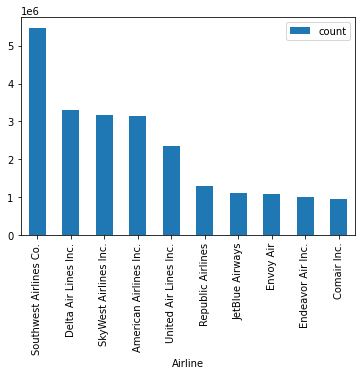

In [ ]:
airlines_mkt_share.toPandas().plot(kind='bar', x="Airline", y="count")
None

In [ ]:
data.select('Airline').distinct().count()

# Top 10 airlines with most delays

In [ ]:
data.select('Airline', '')